In [7]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [5]:
import numpy as np
from pylab import *  # plotting library 
from numba import jit
import matplotlib.animation as am

@jit(nopython = True)
def MCstep_jit(N, L, T,h, state, acceptedMoves, energy, magnetization):

    randomPositions = L * np.random.random(2*N)
    randomArray = np.random.random(N)
    
    for k in range(N):

        i = int(randomPositions[2*k])
        j = int(randomPositions[2*k+1])
        
        dE = 2*state[i, j] * (state[(i+1)%L, j] + state[i-1, j] + state[i, (j+1)%L] + state[i, j-1]) + h*state[i,j]
        
        if dE <= 0 or np.exp(-dE/T) > randomArray[k]:
            acceptedMoves += 1
            newSpin = -state[i, j] # flip spin
            state[i, j] = newSpin
            energy += dE
            magnetization += 2*newSpin

    return state, acceptedMoves, energy, magnetization

@jit(nopython = True)
def raster_MCstep_jit(N, L, T, h, state, acceptedMoves, energy, magnetization):

    randomArray = np.random.random(N)
    
    L1 = L - 1
    for i in range(L):
        for j in range(L):
            
            # i+L1%L performs periodic BC's when array[-1] does not work

            dE = 2*state[i, j] * (state[(i+1)%L, j] + state[(i+L1)%L, j] + state[i, (j+1)%L] + state[i, (j+L1)%L])
        
            if dE <= 0 or w[dE] > randomArray[i*L + j]:
                acceptedMoves += 1
                newSpin = -state[i, j] # flip spin
                state[i, j] = newSpin
                energy += dE
                magnetization += 2*newSpin

    return state, acceptedMoves, energy, magnetization



class Ising2D (object):

    """Class that describes equilibrium statistical mechanics of the two-dimensional Ising model"""

    def __init__(self, L=32, temperature=10.0, field = 0):

        #np.random.seed(222)
        
        self.L = L
        self.N = L**2
        
        self.temperature = temperature
        self.field = field
        
        self.w = zeros(9) # store Boltzmann weights
        self.w[8] = exp(-8.0/self.temperature)
        self.w[4] = exp(-4.0/self.temperature)
        
        self.state = ones((self.L, self.L), int) # initially all spins up
        self.energy = - 2 * self.N
        self.magnetization = self.N
        
        self.reset()


    def increment_T(self, T_increment, reset = True):

        T_new = self.temperature + T_increment
        
        if T_new <= 0:
            T_new = self.temperature

        # self.w[8] = exp(-8.0/T_new)
        # self.w[4] = exp(-4.0/T_new)

        self.temperature = T_new
        if reset:
            self.reset()

    def increment_h(self, h_increment, reset = True):

        h_new = self.field + h_increment
        
        # self.w[8] = exp(-8.0/T_new)
        # self.w[4] = exp(-4.0/T_new)

        self.field = h_new
        if reset:
            self.reset()

            
    def reset(self):

        self.monteCarloSteps = 0
        self.acceptedMoves = 0
        self.energyArray = array([], int)
        self.magnetizationArray = array([], int)
            
            
    def monteCarloStep(self):

        N = self.N
        L = self.L
        w = self.w
        T = self.temperature
        h = self.field
        
        state = self.state
        acceptedMoves = self.acceptedMoves
        energy = self.energy
        magnetization = self.magnetization

        state, acceptedMoves, energy, magnetization = MCstep_jit(N, L, T, h, state, acceptedMoves, energy, magnetization)

        self.state = state
        self.acceptedMoves = acceptedMoves
        self.energy = energy
        self.magnetization = magnetization
        
        self.energyArray.append(self.energy)
        self.magnetizationArray.append(self.magnetization)
        self.monteCarloSteps += 1
        
    def rasterMonteCarloStep(self):

        N = self.N
        L = self.L
        w = self.w
        
        state = self.state
        acceptedMoves = self.acceptedMoves
        energy = self.energy
        magnetization = self.magnetization


        state, acceptedMoves, energy, magnetization = raster_MCstep_jit(N, L, w, state, acceptedMoves, energy, magnetization)

        self.state = state
        self.acceptedMoves = acceptedMoves
        self.energy = energy
        self.magnetization = magnetization
        
        self.energyArray.append(self.energy)
        self.magnetizationArray.append(self.magnetization)
        self.monteCarloSteps += 1

      
    def steps(self, number = 100):

        self.energyArray = self.energyArray.tolist()
        self.magnetizationArray = self.magnetizationArray.tolist() 
       
        for i in range(number):
            self.monteCarloStep()
            # self.rasterMonteCarloStep()

        self.energyArray = np.asarray(self.energyArray)
        self.magnetizationArray = np.asarray(self.magnetizationArray) 

                
    # Observables
    def meanEnergy(self):
        return self.energyArray.mean() / self.N

    def specificHeat(self):
        return (self.energyArray.std() / self.temperature)**2 / self.N
            
    def meanMagnetization(self):
        return self.magnetizationArray.mean() / self.N

    def susceptibility(self):
        return (self.magnetizationArray.std())**2 / (self.temperature * self.N)
            
    def observables(self):
        print("\nTemperature = ", self.temperature)
        print("Mean Energy = ", self.meanEnergy())
        print("Mean Magnetization = ", self.meanMagnetization())
        print("Specific Heat = ", self.specificHeat())
        print("Susceptibility = ", self.susceptibility())
        print("Monte Carlo Steps = ", self.monteCarloSteps, " Accepted Moves = ", self.acceptedMoves)

                    
    # Visual snapshot of state
    def plot(self):

        pcolormesh(self.state, edgecolor = 'k', cmap = 'binary')



def T_dep():
    t_incr = -0.1
    T = 5 
    model = Ising2D(temperature = T, L = 50)   # Tc = 2.3
    Cp = []
    Chi = []
    M = []
    E = []
    Temp = []

    while T > 1.0 :

        model.steps(number=1000)
        model.reset()
        model.steps(number=10000)
        Cp.append(model.specificHeat())
        Chi.append(model.susceptibility())
        M.append(model.meanMagnetization())
        E.append(model.meanEnergy())
        Temp.append(T)
       
        model.increment_T(t_incr)

        T = model.temperature

    Cp = np.array(Cp)
    Chi = np.array(Chi)
    M = np.array(M)
    E = np.array(E)
    Temp = np.array(Temp)

    return Temp, E, M, Cp, Chi


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0.98, 'Antiferromagnetic Ising Spins (Monte Carlo)')

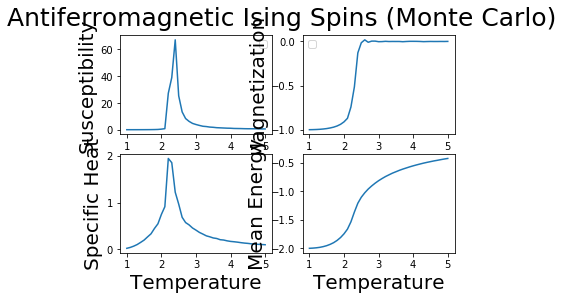

In [4]:
Temp, E, M, Cp, Chi = T_dep()

fig = plt.figure()

ax = []
for i in range(4):
    ax_temp = fig.add_subplot(2,2,i+1)
    ax.append(ax_temp)

ax[0].plot(Temp, Chi)
ax[1].plot(Temp, M)
ax[2].plot(Temp, Cp)
ax[3].plot(Temp, E)

ax[0].set_xlabel("Temperature", fontsize = 20)
ax[1].set_xlabel("Temperature", fontsize = 20)
ax[2].set_xlabel("Temperature", fontsize = 20)
ax[3].set_xlabel("Temperature", fontsize = 20)

ax[0].set_ylabel("Susceptibility", fontsize = 20)
ax[1].set_ylabel("Magnetization", fontsize = 20)
ax[2].set_ylabel("Specific Heat", fontsize = 20)
ax[3].set_ylabel("Mean Energy", fontsize = 20)

fig.suptitle("Antiferromagnetic Ising Spins (Monte Carlo)", fontsize = 25)